In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF

# append source
import os,sys
ck_g_cnn_source =  os.path.join(os.getcwd(),'..')
if ck_g_cnn_source not in sys.path:
    sys.path.append(ck_g_cnn_source)

from ck_g_cnn.groups import SE2

from ck_g_cnn.nn import CKGCNN

from ck_g_cnn.nn.conv import GroupConv, GroupConvSeparable
from ck_g_cnn.nn.conv import GroupConvBlock
from ck_g_cnn.nn.conv import LiftingConv


from demo.utils import visualize_activations

# 0. Configuration

This section contains parameters used throughout the notebook. These can be changed to inspect their impact on the resulting activations.

In [26]:
plt.rcParams['figure.figsize'] = [20, 15]

kernel_size = 7
in_channels = 1
out_channels = 2
out_channels_group = 2
ck_net_num_hidden = 2
ck_net_hidden_size = 32
ck_net_implementation = "SIREN"
ck_net_first_omega_0=30
ck_net_omega_0=10
sampling_method="discretise"
stride=1
padding=1


# group is set to include 8 elements
num_elements = 8
group_elements = torch.linspace(0, 360 * float(num_elements - 1) / float(num_elements), num_elements)

se2 = SE2()

The following samples from the MNIST dataset are used to obtain activations for:

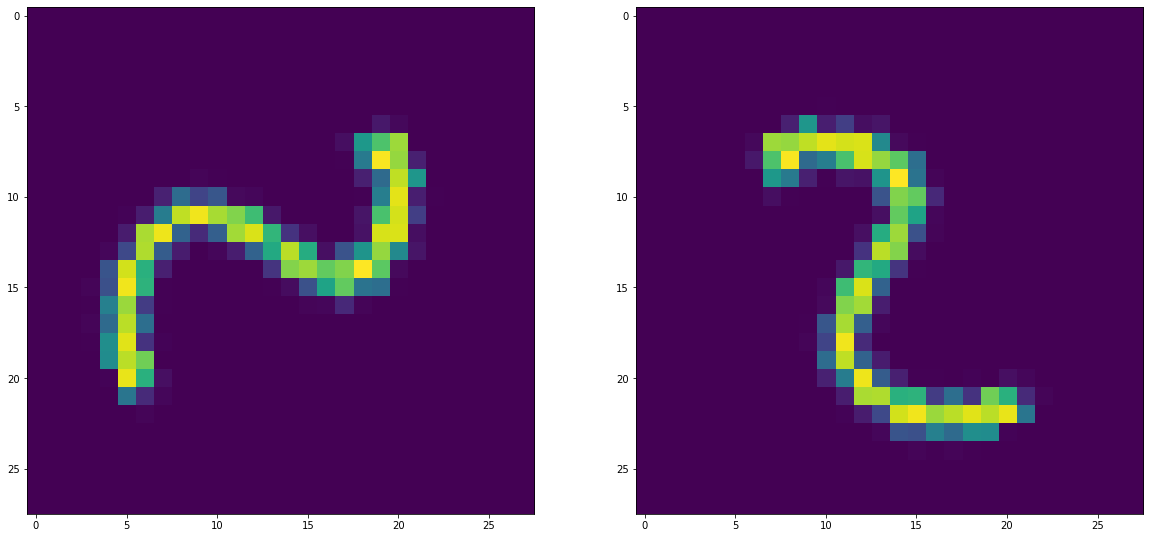

In [27]:
from datasets import get_dataloader, get_num_in_channels, get_num_out_channels, ImplementedDatasets

data_loader = get_dataloader(
    ImplementedDatasets.MNIST_rot,
    batch_size=8,
    root="../../data",
    train=False
)

# obtain a set of samples
samples, _ = next(iter(data_loader))
# rotate the set of samples
samples_rot = TF.rotate(samples, 90)

no_rows = 1
no_cols = 2

fig = plt.figure()
ax_1 = fig.add_subplot(1, 2, 1)
ax_1.imshow(samples[0, 0, :, :])
ax_1 = fig.add_subplot(1, 2, 2)
ax_1.imshow(samples_rot[0, 0, :, :])

plt.show()

# 1. Visualising activations at initalisation

In this section, the activations for lifting and group convolutions are visualised. Note that the convolution filters used in this section are filters at intialisation.

## 1.1 Visualising lifting convolution activations

First, the activations for two different implementations of the lifting convolution layer (based on discrete and continuous implementations of the group) are visualised.

### 1.1.1 Lifting convolution activations

In [28]:
lifting_conv = LiftingConv(
    group=se2,
    kernel_size=kernel_size,
    num_group_elem=num_elements,
    in_channels=in_channels,
    out_channels=out_channels,
    ck_net_num_hidden=ck_net_num_hidden,
    ck_net_hidden_size=ck_net_hidden_size,
    ck_net_implementation=ck_net_implementation,
    ck_net_first_omega_0=ck_net_first_omega_0,
    ck_net_omega_0=ck_net_omega_0,
    sampling_method=sampling_method,
    stride=stride,
    padding=padding
)

Below we visualize the activations for the original sample, for a single output channel. Essentially, here show the rotation axis of the feature map corresponding to the first output channel; each image corresponds to a rotation group element.

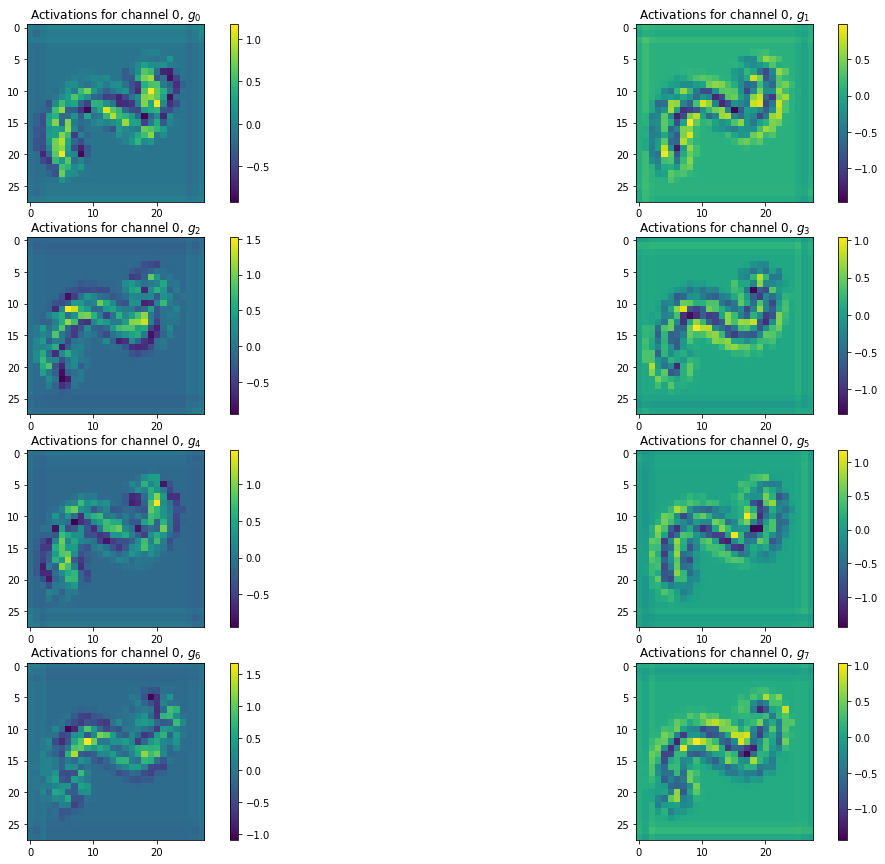

In [29]:
lifting_conv_acts, grid_H = lifting_conv(samples)
visualize_activations(lifting_conv_acts.detach().numpy())

Next, we visualize the activations for the rotated sample, again for a single output channel. Note that the input sample has been rotated by 90 degrees. As we have discretised the rotation group into 8 elements, this means every respective element corresponds to an increase in rotation by 45 degrees. A rotation on the input of 90 degrees means a shift in activations along the group axis of two elements, along with a rotating motion of 90 degrees. So, the activations for channel 0 $g_0$ above have rotated 90 degrees and moved to channel 0 $g_2$ below!

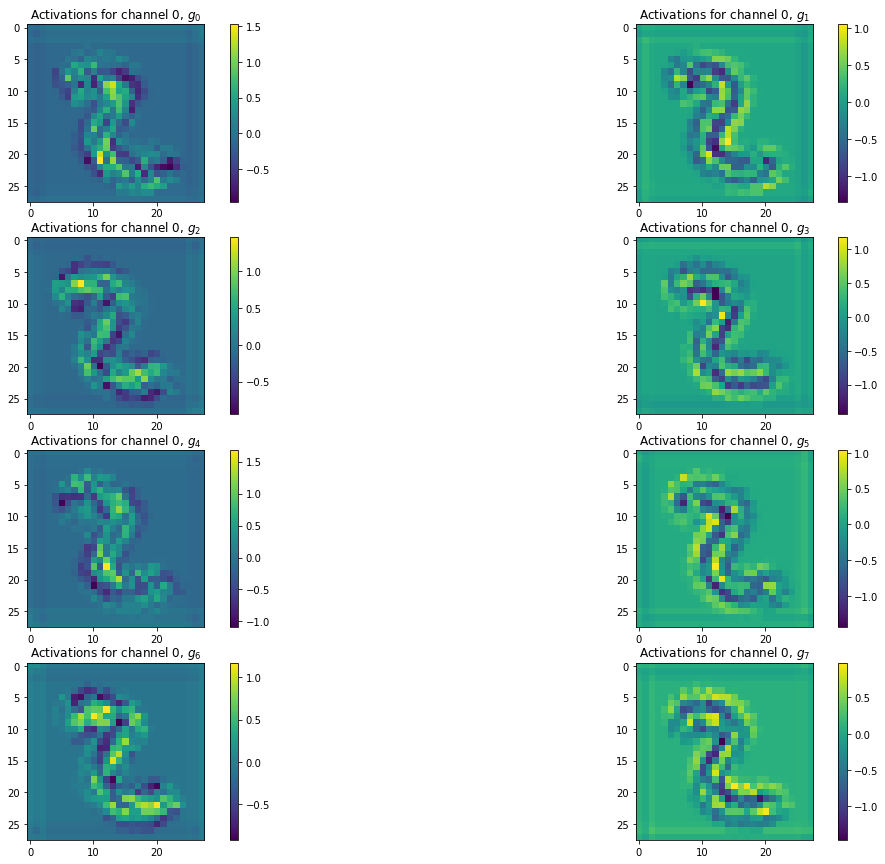

In [30]:
lifting_conv_acts_rot, _ = lifting_conv(samples_rot)
visualize_activations(lifting_conv_acts_rot.detach().numpy())

## 1.2 Group convolution activations

### 1.2.1 Full group convolution activations

In [31]:
gconv = GroupConv(
    group=se2,
    kernel_size=kernel_size,
    num_group_elem=num_elements,
    in_channels=out_channels,
    out_channels=out_channels,
    ck_net_num_hidden=ck_net_num_hidden,
    ck_net_hidden_size=ck_net_hidden_size,
    ck_net_implementation=ck_net_implementation,
    ck_net_first_omega_0=ck_net_first_omega_0,
    ck_net_omega_0=ck_net_omega_0,
    sampling_method=sampling_method,
    stride=stride,
    padding=padding
)

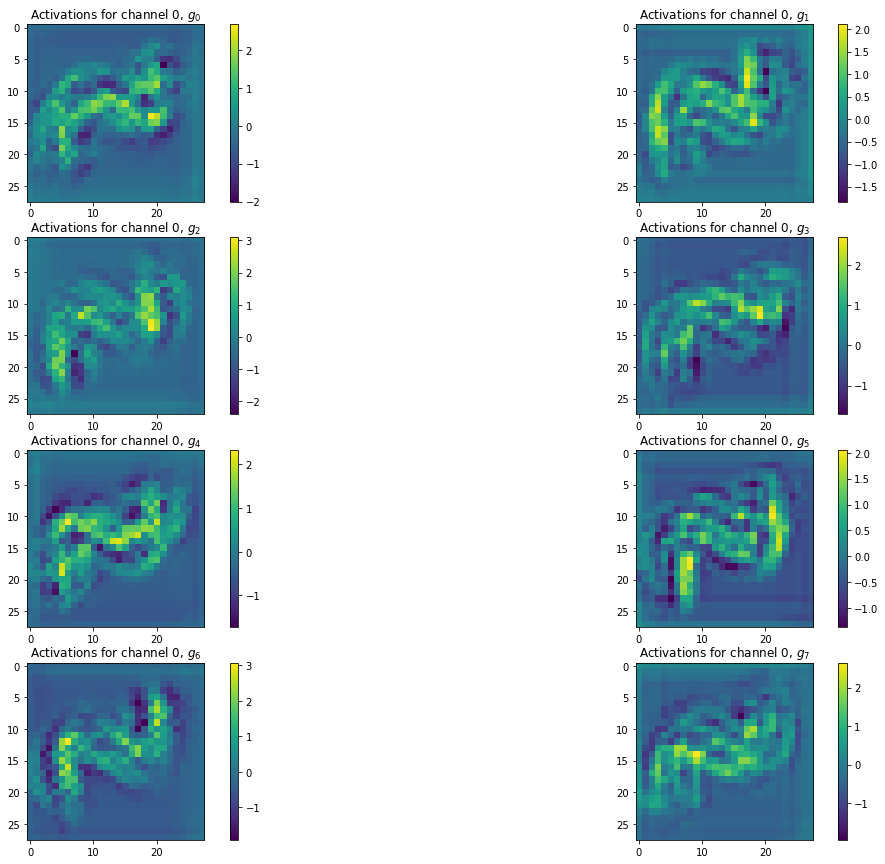

In [32]:
group_conv_acts, _ = gconv(lifting_conv_acts, grid_H)
visualize_activations(group_conv_acts.detach().numpy())

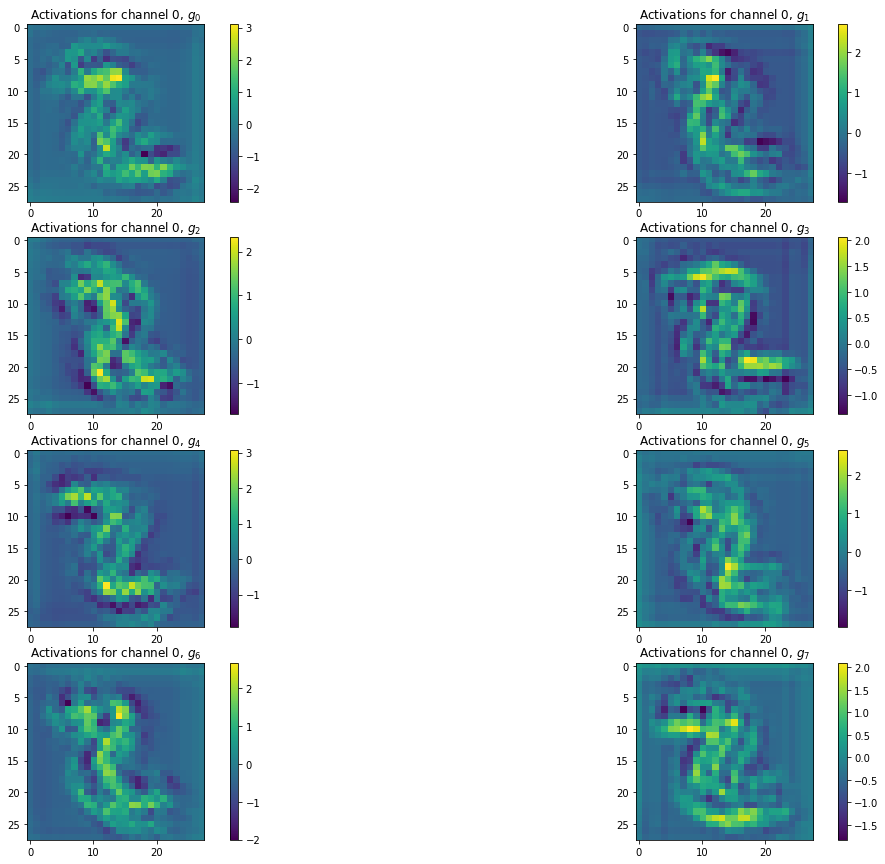

In [33]:
group_conv_acts_rot, _ = gconv(lifting_conv_acts_rot, grid_H)
visualize_activations(group_conv_acts_rot.detach().numpy())

### 1.2.2 Separable group convolution activations

In [34]:
gconv = GroupConvSeparable(
    group=se2,
    kernel_size=kernel_size,
    num_group_elem=num_elements,
    in_channels=out_channels,
    out_channels=out_channels,
    ck_net_num_hidden=ck_net_num_hidden,
    ck_net_hidden_size=ck_net_hidden_size,
    ck_net_implementation=ck_net_implementation,
    ck_net_first_omega_0=ck_net_first_omega_0,
    ck_net_omega_0=ck_net_omega_0,
    sampling_method=sampling_method,
    stride=stride,
    padding=padding
)

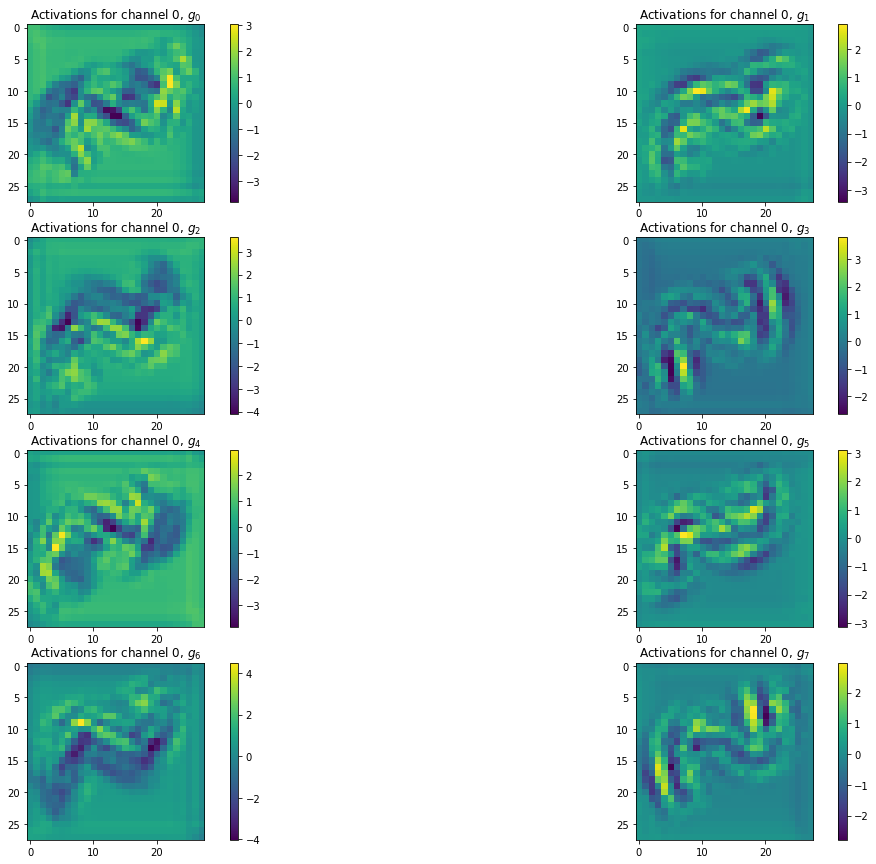

In [35]:
group_conv_acts, _ = gconv(lifting_conv_acts, grid_H)
visualize_activations(group_conv_acts.detach().numpy())

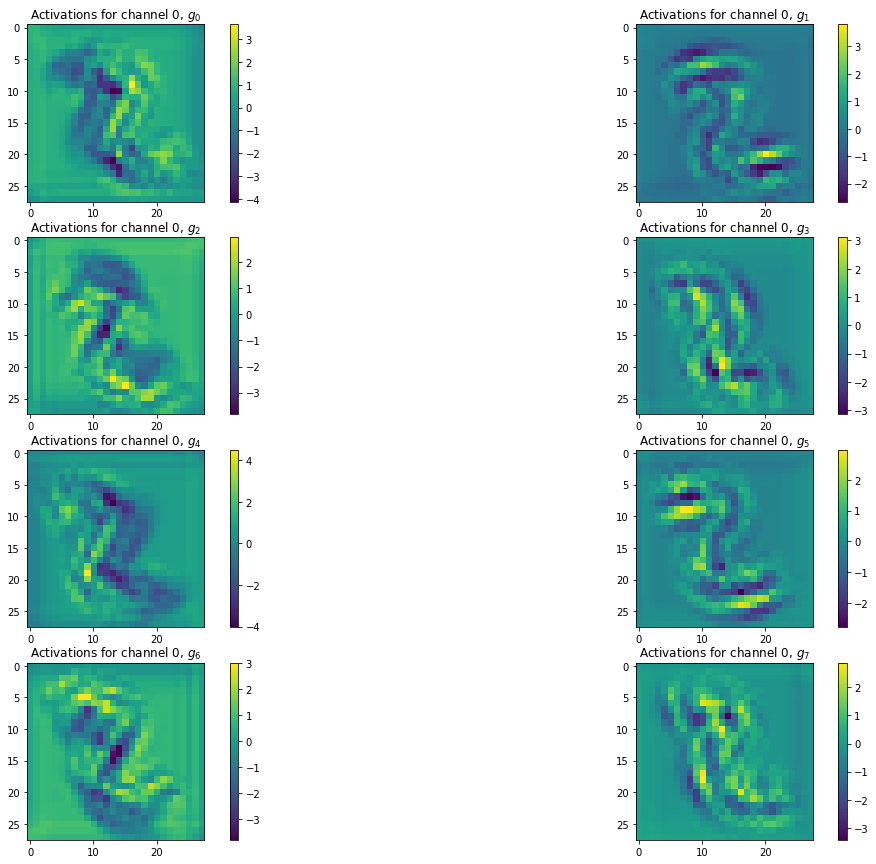

In [36]:
group_conv_acts_rot, _ = gconv(lifting_conv_acts_rot, grid_H)
visualize_activations(group_conv_acts_rot.detach().numpy())